# Run-time Evaluation

We'll start with our standard set of initial imports

In [1]:
%matplotlib inline

import sys
import math
import outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

prescription = pd.read_csv('data/prescriptions_sample.csv.gz', compression='gzip')

In [2]:
medications = outliers.getOverdoseMedications(prescription)
medications.shape

(21,)

## Run-time Folds

For each medication (with more than 10K records) we split the data in 10 fold of 1K.

In each iteration we increase 1K records and run the algorithm again.

We compute the mean time for 3 medications

In [3]:
all_times  = []

for med in np.asarray(medications):

    methods_time = pd.DataFrame()
    
    X, Y = outliers.getPrescriptions(prescription, med)
    anomalies = len(Y[Y==1])
    total = len(X)
    
    if len(X) < 10000:
        continue

    print('')
    print(med + ', Size: ', total, ' Overdose: ', anomalies)
        
    index_list = np.append([], [])
    skf = StratifiedKFold(n_splits=anomalies)
    div = 1
    for train_index, test_index in skf.split(X, Y):
            
            
        index_list = np.append(index_list.astype(int), test_index.astype(int))
        size = len(index_list)
            
        X_train = X[index_list]
        Y_train = Y[index_list]
        overdose_size = len(Y_train[Y_train==1])
        
        if (size // 1000) < div:
            continue
            
        size_idx = div * 1000
        div = 1 + (size // 1000)
        
        sys.stdout.write(str(overdose_size) + '/' + str(size) +', ')
            
        epsilon = 0.5
        results = outliers.evaluateMethods(X_train, Y_train, epsilon, debug=False)

        for idx in results.index:
            methods_time.loc[idx, size_idx] = results.loc[idx,'Time']

        if size > 10000:
            break

    all_times.append(methods_time)
        #break
    
    if len(all_times) > 5:
        break
            
print('Done')


ANLODIPINO, Size:  10392  Overdose:  38
4/1096, 8/2192, 11/3014, 15/4110, 19/5205, 22/6024, 26/7116, 30/8208, 33/9027, 37/10119, 
CETOPROFENO, Size:  10907  Overdose:  45
5/1215, 9/2187, 13/3159, 17/4131, 21/5099, 25/6067, 29/7035, 33/8003, 38/9213, 42/10181, 
PARACETAMOL, Size:  10811  Overdose:  25
3/1299, 5/2165, 7/3031, 10/4330, 12/5195, 14/6059, 17/7355, 19/8219, 21/9083, 24/10379, Done


## One Table Result

In [4]:
all_times[1]

,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000
LOF,0.143,0.278,0.422,0.587,0.757,0.936,1.126,1.377,1.639,1.863
Gau,0.004,0.005,0.006,0.007,0.008,0.008,0.009,0.010,0.011,0.012
DDC-C,0.021,0.027,0.027,0.028,0.034,0.034,0.035,0.035,0.036,0.036
DDC-H,0.019,0.023,0.024,0.024,0.028,0.026,0.027,0.027,0.028,0.028
SVM,0.027,0.076,0.152,0.265,0.395,0.555,0.738,0.976,1.495,1.718
IsoF,0.147,0.193,0.234,0.276,0.316,0.356,0.393,0.437,0.490,0.526
Cov,0.233,0.267,0.291,0.311,0.333,0.363,0.379,0.406,0.429,0.461
DDC,0.018,0.022,0.023,0.024,0.026,0.026,0.027,0.027,0.028,0.030
DDC-J,0.017,0.020,0.021,0.023,0.024,0.024,0.025,0.025,0.026,0.028


## Mean Table Result

In [6]:
mean_time = pd.DataFrame(np.zeros((9,10)), index=results.index, columns=np.arange(1000,10001,1000))

for df in all_times:
    for m in df.index:
        for s in df.columns:
            mean_time.loc[m,s] += df.loc[m,s]

mean_time = ( mean_time.values / len(all_times) )
mean_time = pd.DataFrame(mean_time, index=results.index, columns=np.arange(1000,10001,1000))
mean_time

,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000
LOF,0.125000,0.253667,0.380333,0.554333,0.704667,0.855000,1.030667,1.242333,1.425000,1.647333
Gau,0.005667,0.006667,0.008333,0.009333,0.010667,0.011333,0.014333,0.016333,0.017667,0.017667
DDC-C,0.032000,0.040000,0.043667,0.047000,0.053000,0.056667,0.062333,0.069667,0.070333,0.077667
DDC-H,0.026000,0.031000,0.033000,0.034667,0.039333,0.040667,0.046333,0.049000,0.050000,0.054333
SVM,0.031333,0.091333,0.179667,0.336000,0.516000,0.683333,0.972667,1.278667,1.697667,2.104000
IsoF,0.150000,0.199667,0.240000,0.297000,0.342667,0.382000,0.439667,0.488333,0.540333,0.597000
Cov,0.238333,0.270333,0.294000,0.317000,0.342667,0.371000,0.388667,0.417000,0.439000,0.469333
DDC,0.024667,0.029000,0.031333,0.033667,0.036333,0.038667,0.042667,0.056667,0.046667,0.050333
DDC-J,0.022000,0.025333,0.027000,0.029000,0.031000,0.032667,0.035000,0.037000,0.038000,0.041333


## Run-time Plot

Here we plot the running time for each algorithm

Look that SVM and LOF have a exponential time for the number of instances

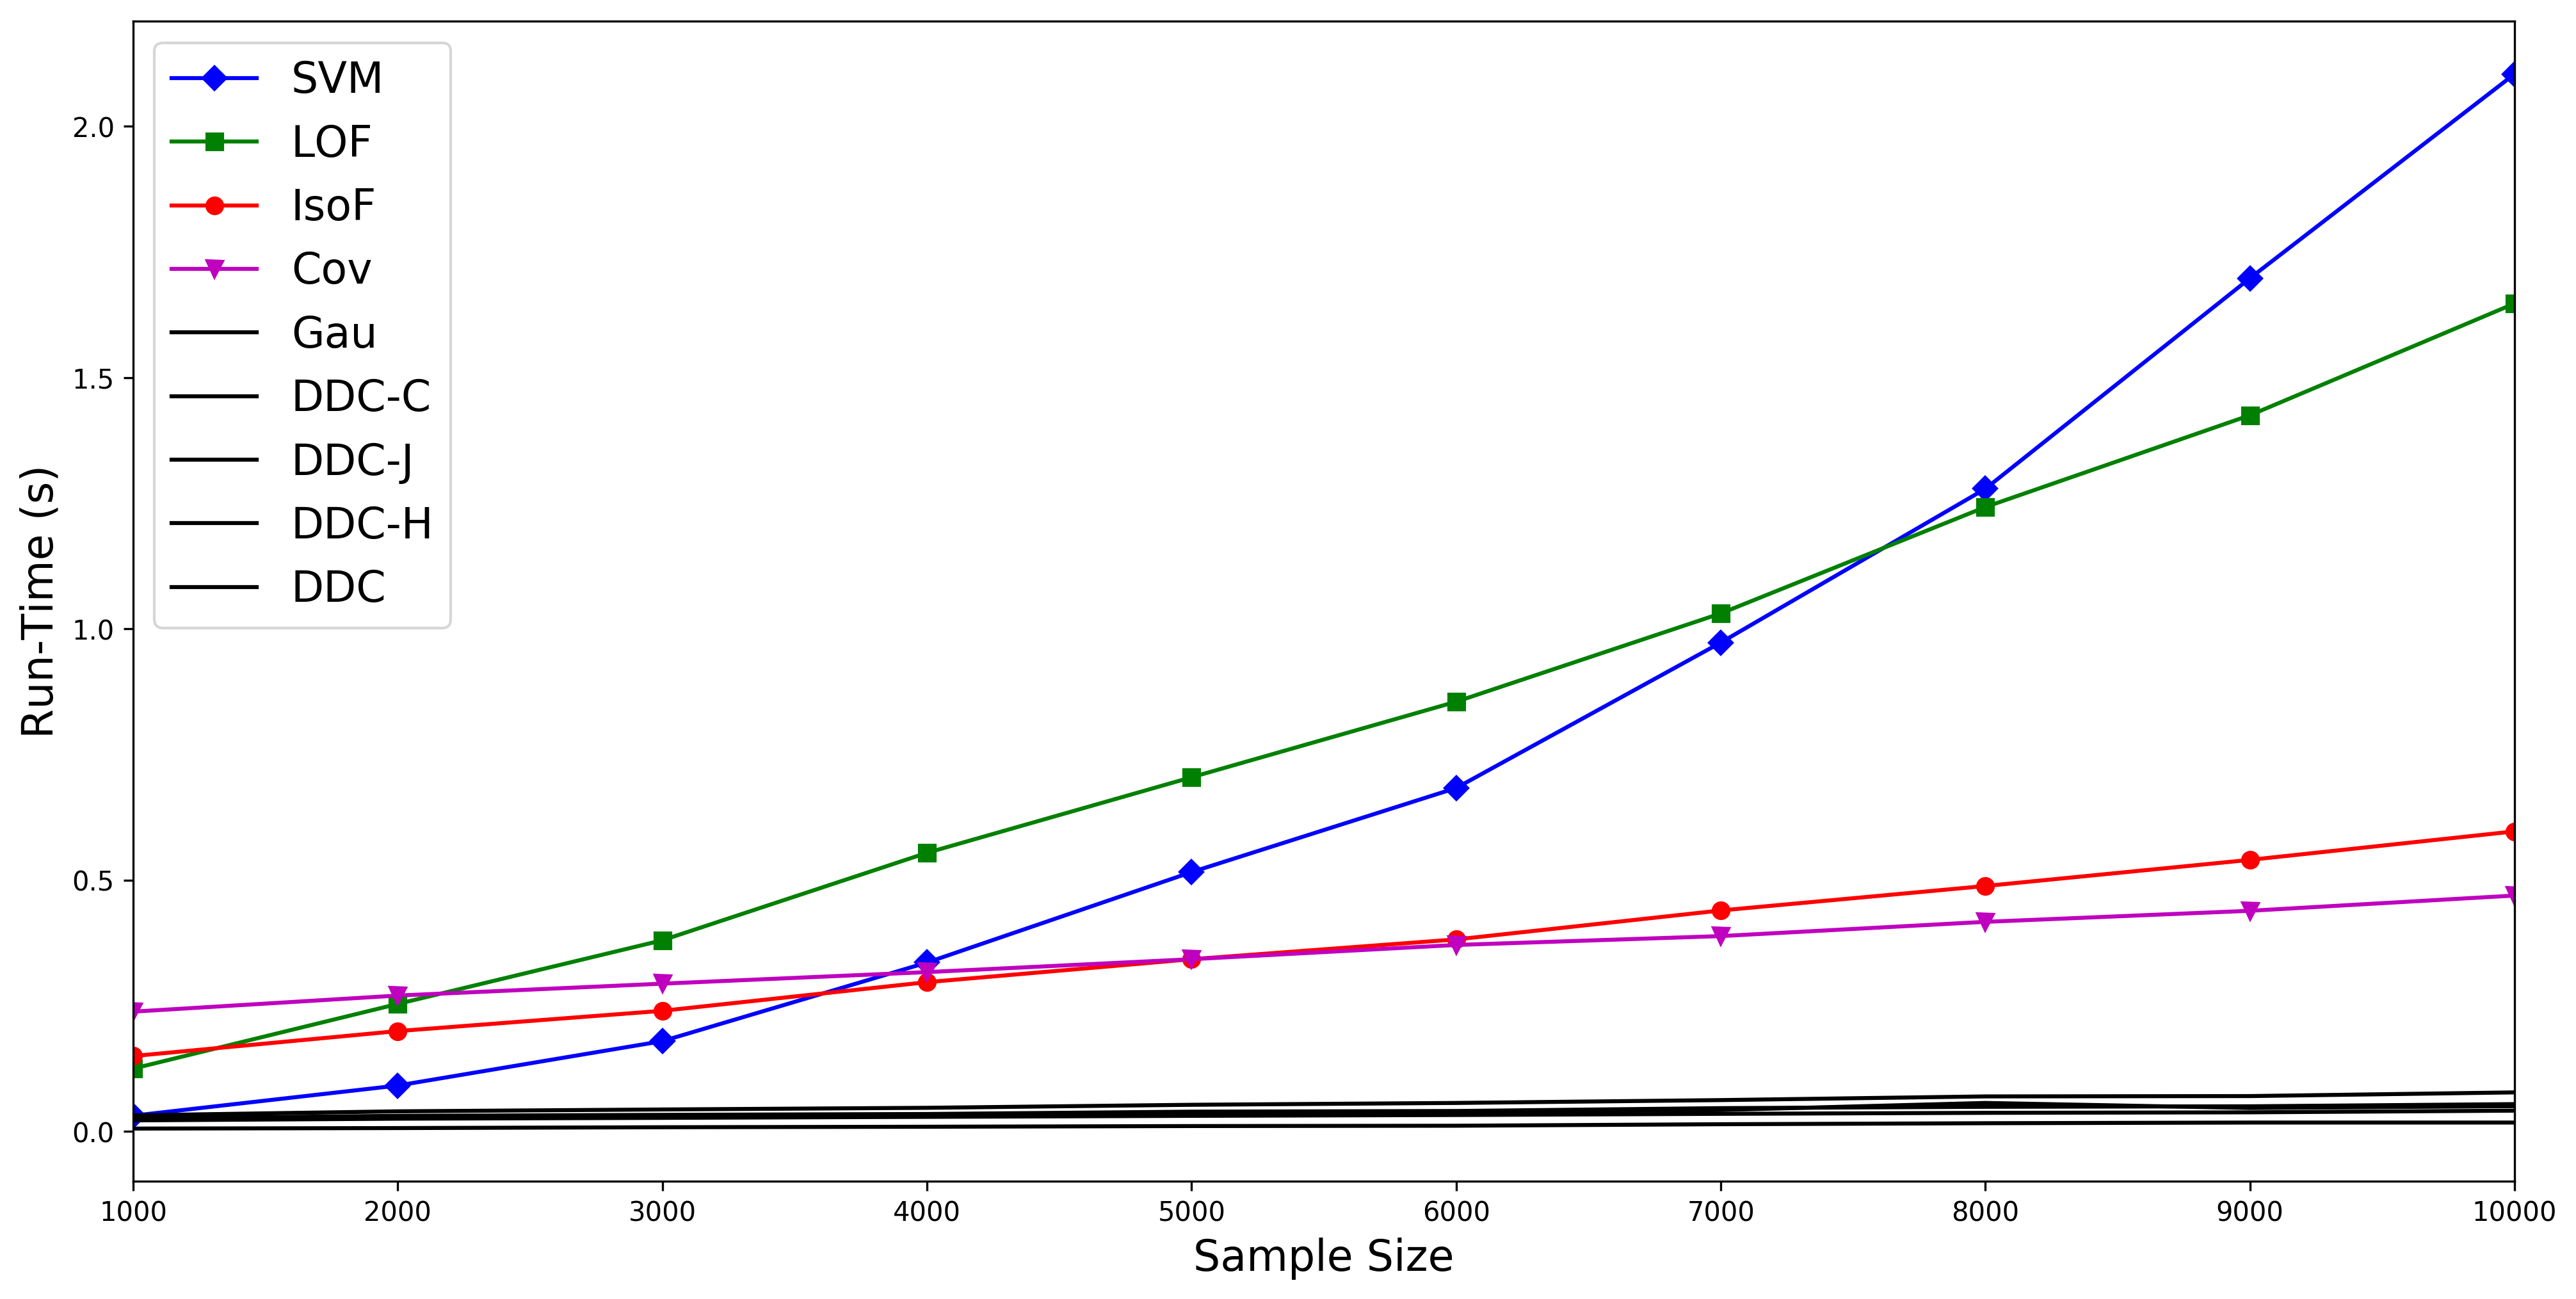

In [7]:
plt.figure(figsize=(16, 8), dpi= 300)
methods = ['SVM','LOF','IsoF','Cov','Gau','DDC-C','DDC-J','DDC-H','DDC']
colors = ['b', 'g', 'r', 'm', 'k', 'k', 'k', 'k', 'k', 'k']
markers = ['D', 's', 'o', 'v', '', '', '', '', '', '']
i = 0
for m in methods:
    plt.plot(np.asarray(mean_time.columns),np.asarray(mean_time.loc[m].values), 
             c=colors[i],
             marker=markers[i],
             label=m)
    i += 1
    
plt.legend(fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Run-Time (s)', fontsize=16)
#plt.ylim(0,22)
plt.xlim(1000,10000)
plt.show()